In [3]:
import matplotlib as mpl
#print(mpl.__version__)
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import random
from IPython.html.widgets import *

C:\ProgramData\Anaconda3\lib\site-packages\IPython\html.py:14: ShimWarning: The `IPython.html` package has been deprecated since IPython 4.0. You should import from `notebook` instead. `IPython.html.widgets` has moved to `ipywidgets`.
  "`IPython.html.widgets` has moved to `ipywidgets`.", ShimWarning)


In [4]:
# Calculates Covariance Matrix with exponential kernel
# Returns the matrix in 2d array
def calculateCovarianceMatrix(x, length, coef, heat):
    if type(x) != 'numpy.ndarray':
        x = np.array(x).reshape(len(x),1)
    K = np.zeros((len(x), len(x)))
    for i in range(len(x)):
        xi = np.full((len(x),1), x[i])
        K[i] = np.power(coef,2)*np.exp(-np.multiply(np.linalg.norm(xi-x,axis=1),np.linalg.norm(xi-x,axis=1))/(2*length*length))
    if heat==1:
        fig = plt.figure(figsize=(7,5))
        ax = fig.add_subplot(111)
        ax.set_title("Covariance Matrix")
        sns.heatmap(K)
    return K
def askForOutput(x):
    if type(x) != 'numpy.ndarray':
        x = np.array(x).reshape((len(x),1))
    n = np.array(np.random.normal(0, 0.25, len(x))).reshape((len(x),1))
    return np.sin(2*np.pi*x) + n

# Fits a Gaussian Process Model with the training data
# Returns Inv of Noisy Covariance Matrix in 2d array
def fit(x, length, coef, noise, heat):
    K = calculateCovarianceMatrix(x, length, coef, heat)
    NoisyK = K + np.power(noise,2)*np.identity(len(K))
    NoisyK_inv = np.linalg.pinv(NoisyK)
    return NoisyK, NoisyK_inv

# Predicts output and std deviation
# Returns input, true and predicted output and deviation
def predict(X_test, y_test, X_train, y_train, Ky_inv, length, coef, noise):
    if type(X_train) != 'numpy.ndarray':
        X_train = np.array(X_train).reshape((len(X_train),1))
    if type(y_train) != 'numpy.ndarray':
        y_train = np.array(y_train).reshape((len(y_train),1))
    if type(X_test) != 'numpy.ndarray':
        X_test = np.array(X_test).reshape((len(X_test),1))
    if type(y_test) != 'numpy.ndarray':
        y_test = np.array(y_test).reshape((len(y_test),1))
    X_train_vect = np.full((len(X_test),len(X_train)), X_train.T)
    corrVec = np.power(coef,2)*np.exp(-np.multiply(X_train_vect-X_test,X_train_vect-X_test)/(2*length*length))
    correlationWithItself = np.power(coef,2)
    posterior_mean = np.zeros((len(X_test),1))
    for i in range(len(corrVec)):
        cv = corrVec[i].reshape(1,len(X_train))
        posterior_mean[i] = (cv.dot(Ky_inv)).dot(y_train)
    posterior_cov = np.zeros((len(X_test),1))
    for i in range(len(corrVec)):
        cv = corrVec[i].reshape(1,len(X_train))
        posterior_cov[i] = correlationWithItself - (cv.dot(Ky_inv)).dot(cv.T)
    minus = (posterior_mean - 3 * np.sqrt(np.abs(posterior_cov)))
    plus = (posterior_mean + 3 * np.sqrt(np.abs(posterior_cov)))
    data = np.hstack((np.hstack((np.hstack((np.hstack((np.hstack((X_test, y_test)),posterior_mean)),posterior_cov)),plus)),minus))
    e = y_test - posterior_mean
    err = np.multiply(e,e)
    return data

### Model

Let's say we have the function mapping inputs to outputs as
$$ y  f(x) = \sin(2\pi x) $$

<IPython.core.display.Javascript object>


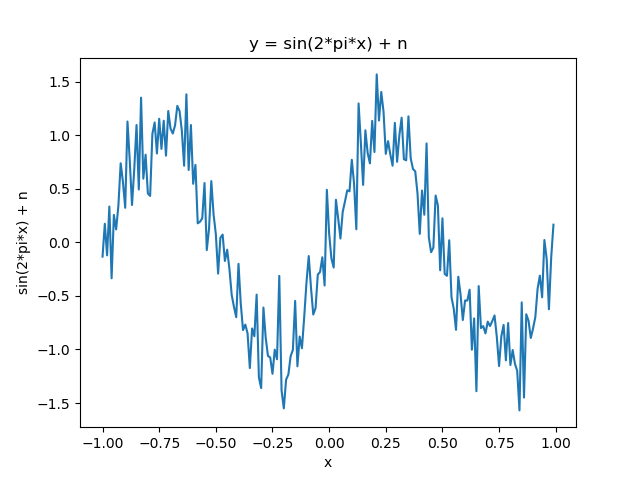

In [5]:
x_true = np.arange(-1,1,0.01)
y_true = askForOutput(x_true)#np.sin(2*np.pi*x_true)
plt.plot(x_true,y_true)
plt.title("y = sin(2*pi*x) + n")
plt.xlabel("x")
plt.ylabel("sin(2*pi*x) + n")
plt.show()

### Estimating the function

We would like to estimate this sine function with Gaussian Process Regression. By selecting training data one by one and fitting a Gaussian Process based on this data, we become able to make predictions  for the inputs in the range of (-1,1,0.01). While doing this, we need to keep error under a threshold and we need to select training data wisely in order to avoid to much time to spend for training data generation. 

### Cost Function


Considering selection of a new training data, there are two types of cost:

1) Measurement cost ($c_m$): the cost spent for measuring the particular data. Measuring the initial data requires setup cost in contrast to measuring the oncoming data. Except the initial data, as more and more data measured, we can assume measurement cost increase linearly for the simplicity. 

2) Error ($c_e$): the cost of discrepancy between real output values and the predictions. It can be evaluated at validation inputs. 

For some problems, measurement cost can be excused in return of decreasing the error as much as possible whereas for some other problems, error cost can be excused at the cost of measuring a new data. So, taking both in hand makes sense as the total cost.

We equate total cost to following and compare the results

1) $\text{Total cost = Measurement Cost + Error Cost}$

$ \ \ \ c_{tot} = c_m + c_e $

2) $\text{Total cost = Measurement Cost * Error Cost}$

$ \ \ \ c_{tot} = c_m * c_e $

### Design

#### 1. Measurement Cost Design

As we stated we have an initial setup cost for the first measurement, this leads to an offset for measurement cost graph.

Measurement cost of $i^{th}$ data can be represented with the following function, 

$$
f(c_{m_i}) = 
\begin{cases}
  f(c_{m_i}) = \text{setup cost} = 5 \text{ min} & \text{if  } i==0\\    
  f(c_{m_i}) = 1 \text{ min} & \text{otw }   
\end{cases}
$$ 

#### 2. Error  Design

After measuring a new data, we fit the GP and make predictions for the validation data in the range of (-1,1,0.01). 
To evaluate the error, we calculate the difference between $sin(2\pi x)$ and predictions, square them and sum.

$$E = \frac{1}{N}e^Te$$ where N is the # of validation data, in our case $N = 201$ and $e$ is error vector composed of $e_i$'s each of which the error at $i^{th}$ validation data.   

#### 3. Selection Approach

- We select initial data randomly
- Then the one having the maximum variance


In [6]:
def measurementCost(xtrain):
    if len(xtrain)==1:
        c = 0.5
    else:
        c = 0.5 + (len(xtrain)-1)*0.1
    return c

def errorCost(err):
     return np.sum(err,axis=0)
    
def calculateCost(xtrain,err):
    return np.array([measurementCost(xtrain), err, 2*measurementCost(xtrain) + err, 2* measurementCost(xtrain) * err]).reshape((4,1))

#It selects the data having maximum variance 
def selectNext(data):
    data = pd.DataFrame(data,columns=['x','y','y_pred','cov','plus','minus'])
    data = data.sort_values(by=['cov'],ascending=False).reset_index(drop=True)
    return data.iloc[0]['x'],data.iloc[0]['y']

### Active Learining Toy Example

In [7]:
def calculateVariance(x_selected, x, Ky_inv):
    if type(x_selected) != 'numpy.ndarray':
        x_selected = np.array(x_selected).reshape((len(x_selected),1))
    if type(x) != 'numpy.ndarray':
        x = np.array(x).reshape((len(x),1))
    x_vect = np.full((len(x),len(x_selected)), x_selected.T)
    corrVec = np.power(coef,2)*np.exp(-np.multiply(x_vect-x,x_vect-x)/(2*length*length))
    correlationWithItself = np.power(coef,2)
    cov = np.zeros((len(x),2))
    for i in range(len(corrVec)):
        cv = corrVec[i].reshape(1,len(x_selected))
        cov[i][0] = x[i]
        cov[i][1] = correlationWithItself - (cv.dot(Ky_inv)).dot(cv.T)
    cov = pd.DataFrame(cov, columns=['x','cov']).sort_values(by=['cov'],ascending=False)
    return cov

def ax1Setup():
    #ax1 = fig.add_subplot(221)
    ax1.cla()
    ax1.set_title("Standart Deviation")
    ax1.set_xlabel("x")
    ax1.set_ylabel("std dev")
    ax1.set_xlim((-1.1,1.1))
    #ax1.set_ylim((-1.5,1.5))
    xcoords = np.arange(-1,1.1,0.1)
    xticks = np.arange(-1,1.1,0.1)
    yticks = np.arange(-1.5,1.5,0.5)
    ax1.set_xticks(xticks)
#    ax1.set_yticks(yticks)
    for xc in xcoords:
        ax1.axvline(x=xc,linestyle=':')
    
def ax2Setup():
    ax2 = fig.add_subplot(223)
    ax2.cla()
    ax2.set_xlabel("x")
    ax2.set_ylabel("y")
    ax2.set_ylim((-1.5,1.5))
    xticks = np.arange(-1,1.1,0.1)
    yticks = np.arange(-1.5,1.5,0.5)
    ax2.set_xticks(xticks)
    ax2.set_yticks(yticks)
    #ax2.scatter(x_test,y_test,color='blue',marker='x',label='validation data')
    ax2.plot(x_true,y_true,label='sin(2$\pi$x)',linestyle=':')
    ax2.legend(fontsize=10, bbox_to_anchor=(0., -1.2, 1 ,1), loc="upper center", ncol=3)
    plt.tight_layout(h_pad=0)
    return ax2

def ax3Setup():
    ax3 = fig.add_subplot(122)
    ax3.cla()
    ax3.set_xlim((0,21))
    ax3.set_ylim((0,5))
    ax3.set_xticks(np.arange(0,21,1))
    ax3.set_title("Cost Plot")
    return ax3 

def riemannsum(x,y):
    x1 = x[0]
    x2 = x[-1]
    A = 0
    delta_x = 0.01
    it = int(abs(x2-x1)/delta_x)
    xit = x1
    for i in range(it):
        delta_A = abs(y[i]) * delta_x
        xit = xit + delta_x
        A = A + delta_A
    return A

def initialize():
    x_selected = []
    y_selected = []
    selected = np.zeros((21,2))
    total_cost = np.zeros((21,4))
    var = np.zeros((21,2,len(x)))
    for b in range(21):
        if b == 0:
            x0 = np.array(random.sample(list(x), 1)).reshape((1,1))
            y0 = askForOutput(x0)
            x_selected.append(x0)
            y_selected.append(y0)
            selected[b][0] = x0
            selected[b][1] = y0
            Ky, Ky_inv = fit(x_selected, length, coef, noise, 0)
            cov = calculateVariance(x_selected, x, Ky_inv)
        else:
            #x_next is assigned to the value in the x_remaining which has the max variance
            x_next = np.array(cov.iloc[0]['x']).reshape((1,1))
            y_next = askForOutput(x_next)
            x_selected.append(x_next)
            y_selected.append(y_next)
            selected[b][0] = x_next
            selected[b][1] = y_next
            Ky, Ky_inv = fit(x_selected, length, coef, noise, 0)
            cov = calculateVariance(x_selected, x, Ky_inv)
        plotdata = predict(x_true, y_true, x_selected, y_selected, Ky_inv, length, coef, noise)
        plotdata = pd.DataFrame(plotdata,columns=['x','y','y_pred','cov','plus','min']).sort_values(by=['x']).reset_index(drop=True)
        err = abs(riemannsum(x_true,y_true)-riemannsum(list(plotdata.loc[:,'x']),list(plotdata.loc[:,'y_pred'])))
        var[b,0] = cov.sort_values(by=['x'],ascending=True).reset_index(drop=True)['x']
        var[b,1] = cov.sort_values(by=['x'],ascending=True).reset_index(drop=True)['cov']
        for i in range(4):
            total_cost[b][i] = calculateCost(x_selected,err)[i]
    return selected, total_cost, var
    
def iterate(ax1,x,selected,total_cost,var,BATCH,MAX_BATCH):
    ax1Setup()
    ax1.legend(fontsize=10, bbox_to_anchor=(0., -1.2, 1 ,1), loc="upper center", ncol=3)
    plt.tight_layout(h_pad=0)
    ax2 = ax2Setup()
    ax3 = ax3Setup()
    
    s = pd.DataFrame(selected,columns=['x','y'])
    x_s_plot = s[:MAX_BATCH]['x']
    y_s_plot = s[:MAX_BATCH]['y']
    #ax1.scatter(x_s_plot, y_s_plot, color='purple', marker='^', label='actively selected')
         
    #Cost Plot
    tc = pd.DataFrame(total_cost,columns=['M','E','SUM','MULT'])
    numtrainingdata = np.arange(1,len(x_s_plot)+1,1)
    if MAX_BATCH > 0:
        #Fit a GP with the selected x,y 
        Ky, Ky_inv = fit(x_s_plot, length, coef, noise, 0) 
        plotdata = predict(x_true, y_true, x_s_plot, y_s_plot, Ky_inv, length, coef, noise)
        plotdata = pd.DataFrame(plotdata,columns=['x','y','y_pred','cov','plus','min']).sort_values(by=['x']).reset_index(drop=True)
        err = abs(riemannsum(x_true,y_true)-riemannsum(list(plotdata.loc[:,'x']),list(plotdata.loc[:,'y_pred'])))
        # Prediction and true values plotted
        ax2.scatter(x_s_plot,y_s_plot, marker='^', color='purple', label='actively selected')
        ax2.plot(plotdata.loc[:,'x'],plotdata.loc[:,'y_pred'],color='orange', label='predicted function')
        ax2.legend(fontsize=10, bbox_to_anchor=(0., -1.2, 1 ,1), loc="upper center", ncol=3)
        plt.tight_layout(h_pad=0)
        
        #Var plot
        var_x = var[MAX_BATCH-1,0]
        var_v = var[MAX_BATCH-1,1]
        ax1.plot(var_x,np.sqrt(var_v), color='aqua', label='variance')
        #Error plot
        ax3.scatter(numtrainingdata,tc.loc[:MAX_BATCH-1]['M'],label='measurement cost')
        ax3.scatter(numtrainingdata,tc.loc[:MAX_BATCH-1]['E'],label='error cost')
        ax3.scatter(numtrainingdata,tc.loc[:MAX_BATCH-1]['SUM'],label='M + E cost')
        ax3.plot(numtrainingdata,tc.loc[:MAX_BATCH-1]['M'],label='measurement cost')
        ax3.plot(numtrainingdata,tc.loc[:MAX_BATCH-1]['E'],label='error cost')
        ax3.plot(numtrainingdata,tc.loc[:MAX_BATCH-1]['SUM'],label='M + E cost')
    ax3.legend(fontsize=10, bbox_to_anchor=(0., -0.1, 1 ,1), loc="center right", ncol=1)
    BATCH.append(MAX_BATCH)
    
def drawCost(eventx):
    ax2 = ax2Setup()
    ax3 = ax3Setup()
    
    #Finding the corresponding x which is clicked from the plot
    #eventx = np.array(eventx).reshape(len(eventx),1)
    eventx_ = np.full((len(x),1), eventx)
    diff = np.linalg.norm(x.reshape(len(x),1)-eventx_, axis=1)
    idx = np.argmin(diff)
    x_idx = np.array(x[idx]).reshape((1,1))
    y_idx = askForOutput(x_idx)
    
    #Manuel selection plotted
    ax1.scatter(x_idx,y_idx, color='green', marker='o', label='selected')
    ax2.scatter(x_idx,y_idx, marker='o', color='green', label='selected')
      
    x_s_plot = selected[:BATCH[-1],0]
    y_s_plot = selected[:BATCH[-1],1]
    #Active selections plotted
    #ax1.scatter(x_s_plot, y_s_plot, color='purple', marker='^', label='actively selected')
    ax2.scatter(x_s_plot,y_s_plot, marker='^', color='purple', label='actively selected')
    
    new_point = np.hstack((x_idx,y_idx))
    if len(selected[:BATCH[-1]]) != 0:
        new_selected = np.vstack((selected[:BATCH[-1]],new_point))
    else: 
        new_selected = new_point
    new_selected_x = new_selected[:,0]
    new_selected_y = new_selected[:,1]
    
    #Refit with the newly selected
    Ky, Ky_inv = fit(new_selected_x, length, coef, noise, 0)
    plotdata = predict(x_true, y_true, new_selected_x, new_selected_y, Ky_inv, length, coef, noise)
    plotdata = pd.DataFrame(plotdata,columns=['x','y','y_pred','cov','plus','min']).sort_values(by=['x']).reset_index(drop=True)
    err = abs(riemannsum(x_true,y_true)-riemannsum(list(plotdata.loc[:,'x']),list(plotdata.loc[:,'y_pred'])))
    
    new_cost = np.array(calculateCost(new_selected_x,err)).reshape(1,4)
    if len(total_cost[:BATCH[-1]]) != 0:
        new_total_cost = np.vstack((total_cost[:BATCH[-1]],new_cost))
    else: 
        new_total_cost = new_cost
         
    # Prediction and true values plotted
    ax2.plot(plotdata.loc[:,'x'],plotdata.loc[:,'y_pred'],color='orange', label='predicted function')
    ax2.legend(fontsize=10, bbox_to_anchor=(0., -1.2, 1 ,1), loc="upper center", ncol=3)
    plt.tight_layout(h_pad=0)
    
    #Calculate and plot the variance
    cov = calculateVariance(new_selected_x, x, Ky_inv)
    cov = cov.sort_values(by=['x']) 
    ax1.plot(cov['x'],np.sqrt(cov['cov']), label='Variance', color='aqua')    
    ax1.legend(fontsize=10, bbox_to_anchor=(0., -1.2, 1 ,1), loc="upper center", ncol=3)
    plt.tight_layout(h_pad=0)
    
    #Cost Plot
    numtrainingdata = np.arange(1,len(new_selected_x)+1,1)
    tc = pd.DataFrame(new_total_cost,columns=['M','E','SUM','MULT'])
    ax3.scatter(numtrainingdata,tc['M'],label='measurement cost')
    ax3.scatter(numtrainingdata,tc['E'],label='error cost')
    ax3.scatter(numtrainingdata,tc['SUM'],label='M + E cost')

    ax3.plot(numtrainingdata,tc['M'],label='measurement cost')
    ax3.plot(numtrainingdata,tc['E'],label='error cost')
    ax3.plot(numtrainingdata,tc['SUM'],label='M + E cost')
    ax3.set_title("Cost Plot")
    ax3.legend(fontsize=10, bbox_to_anchor=(0., -0.1, 1 ,1), loc="center right", ncol=1)
        
def onclick(event):
    eventx = event.xdata
    ax1Setup()
    #Draw prediction and cost plots
    drawCost(eventx)
    fig.canvas.draw()


<IPython.core.display.Javascript object>


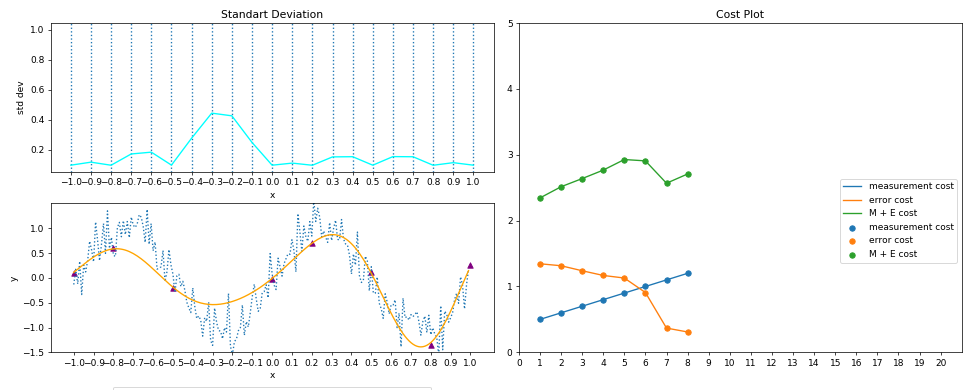

interactive(children=(IntSlider(value=0, description='MAX_BATCH', max=20), Output()), _dom_classes=('widget-interact',))

In [8]:
%matplotlib notebook
import matplotlib as mpl
import matplotlib.pyplot as plt

length=0.25; coef=1; noise=0.1
val_N = 6
x = np.arange(-1,1.1,0.1)
BATCH = []
x_test = np.array(random.sample(list(x), val_N)).reshape((val_N,1)) 
y_test = askForOutput(x_test)
selected, total_cost, var = initialize()
fig = plt.figure(figsize=(15,6), dpi=65)
ax1 = fig.add_subplot(221)
ax1Setup()
interact(iterate,ax1=fixed(ax1),x=fixed(x),selected=fixed(selected),total_cost=fixed(total_cost),var=fixed(var),BATCH=fixed(BATCH),MAX_BATCH=widgets.IntSlider(min=0,max=20,step=1,value=0))#(1,25,1))
cid = fig.canvas.mpl_connect('button_press_event',onclick)

### Active Learning vs Random Learning Comparison